In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.io
import h5py
import cv2
import ot
import Utils
import tensorly
import matplotlib
from Utils import Random_graph
import copy as cp
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.font_manager import FontProperties

%matplotlib inline

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Load datasets
- ### mnist:  60000 train samples /   10000 test samples   /  28x28 /    divided by 255 to normalize /    gray-scale images  /      (n_samples,784)
- ### usps:   7291 train samples  /   2007 test samples    /  16x16 /    it is normalized itsself    /    gray-scale images  /      (n_samples,256)
- ### svhn:   73257 train samples /   26032 test samples   /  32x32 /    divided by 255 to normalize /    RGB images to Gray /      (n_samples,32,32,3)

you can change "reshape parameter" to change the number of features --> output:  **(num_samples, num_features)** 

Note (no need for this paper): label of number zero is 10 in svhn dataset ==> Correct before using it

In [10]:
def load_mnist(path, reshape = (28,28)):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test,  y_test = f['x_test'], f['y_test']
        x_tmp1 = np.zeros((len(y_train),reshape[0],reshape[1]))
        x_tmp2 = np.zeros((len(y_test), reshape[0],reshape[1]))
        if reshape != (28,28):
            for i in range(len(y_train)):
                x_tmp1[i] = cv2.resize(x_train[i], dsize=reshape, interpolation=cv2.INTER_CUBIC )
            for i in range(len(y_test)):
                x_tmp2[i]  = cv2.resize(x_test[i], dsize=reshape, interpolation=cv2.INTER_CUBIC )
        x_train = np.reshape(x_tmp1,(len(y_train),reshape[0]*reshape[1]))
        x_test  = np.reshape(x_tmp2,(len(y_test), reshape[0]*reshape[1]))
    return (x_train/255, y_train), (x_test/255, y_test)

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = \
    load_mnist('/Users/firooz/Desktop/codes/datasets/mnist.npz', reshape=(16,16))

In [11]:
def load_usps(path, reshape = (16,16)):
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        x_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        x_test = test.get('data')[:]
        y_test = test.get('target')[:]
        x_tmp1 = np.zeros((len(y_train),reshape[0],reshape[1]))
        x_tmp2 = np.zeros((len(y_test), reshape[0],reshape[1]))
        if reshape != (16,16):
            for i in range(len(y_train)):
                x_tmp1[i] = cv2.resize(x_train[i].reshape(16,16), dsize=reshape, interpolation=cv2.INTER_CUBIC )
            for i in range(len(y_test)):
                x_tmp2[i]  = cv2.resize(x_test[i].reshape(16,16), dsize=reshape, interpolation=cv2.INTER_CUBIC )
            x_train = np.reshape(x_tmp1,(len(y_train),reshape[0]*reshape[1]))
            x_test  = np.reshape(x_tmp2,(len(y_test), reshape[0]*reshape[1]))
    return (x_train, y_train), (x_test, y_test)

(x_train_usps, y_train_usps), (x_test_usps, y_test_usps) = \
    load_usps('/Users/firooz/Desktop/codes/datasets/usps.h5', reshape = (16,16))

In [12]:
def load_svhn(path_train, path_test, reshape = (32,32)):
    mat1 = scipy.io.loadmat(path_train)    
    mat2 = scipy.io.loadmat(path_test)    
    x_train, y_train = mat1['X'], mat1['y']
    x_test,  y_test  = mat2['X'], mat2['y']
    y_train[y_train == 0] = 0
    y_test[y_test   == 0] = 0
    x_train = np.moveaxis(x_train,-1,0)
    x_test  = np.moveaxis(x_test, -1,0)
    x_tmp1  = np.zeros((len(y_train),reshape[0],reshape[1]))
    x_tmp2  = np.zeros((len(y_test), reshape[0],reshape[1]))
    if reshape != (32,32):
        for i in range(len(y_train)):
            x_tp1     = cv2.cvtColor(np.float32(x_train[i]), cv2.COLOR_BGR2GRAY)
            x_tmp1[i] = cv2.resize(x_tp1, dsize=reshape, interpolation=cv2.INTER_CUBIC )
        for i in range(len(y_test)):
            x_tp2     = cv2.cvtColor(np.float32(x_test[i]), cv2.COLOR_BGR2GRAY)
            x_tmp2[i] = cv2.resize(x_tp2, dsize=reshape, interpolation=cv2.INTER_CUBIC )
    x_train = np.reshape(x_tmp1,(len(y_train),reshape[0]*reshape[1]))
    x_test  = np.reshape(x_tmp2,(len(y_test), reshape[0]*reshape[1]))
    return (x_train/255, y_train), (x_test/255, y_test)

(x_train_svhn, y_train_svhn), (x_test_svhn, y_test_svhn) = \
    load_svhn('/Users/firooz/Desktop/codes/datasets/train_svhn.mat',\
              '/Users/firooz/Desktop/codes/datasets/test_svhn.mat', reshape=(16,16))

### Normalize Dataset, evemthough I have devided them by 255
 - before runnig the following cells, the data is min/max scaled --> [0,1]
 - cell one --> unit norm 
 - cell two --> unit sum


In [13]:
x_train_mnist, x_test_mnist = normalize(x_train_mnist), normalize(x_test_mnist)
x_train_usps,  x_test_usps  = normalize(x_train_usps),  normalize(x_test_usps)
x_train_svhn,  x_test_svhn  = normalize(x_train_svhn),  normalize(x_test_svhn)

In [8]:
# x_train_mnist = x_train_mnist/x_train_mnist.sum(1,keepdims=True)
# x_test_mnist  = x_test_mnist/x_test_mnist.sum(1,keepdims=True)

# x_train_usps  = x_train_usps/x_train_usps.sum(1,keepdims=True)
# x_test_usps   = x_test_usps/x_test_usps.sum(1,keepdims=True)

# x_train_svhn  = x_train_svhn/x_train_svhn.sum(1,keepdims=True)
# x_test_svhn   = x_test_svhn/x_test_svhn.sum(1,keepdims=True)

In [9]:
print(x_train_mnist.shape)
print(x_test_mnist.shape)
print(x_train_usps.shape)
print(x_test_usps.shape)

(60000, 256)
(10000, 256)
(7291, 256)
(2007, 256)


## Visualize data domains
Due to time consideration, only random samples are chosen (percent parameter describes this)

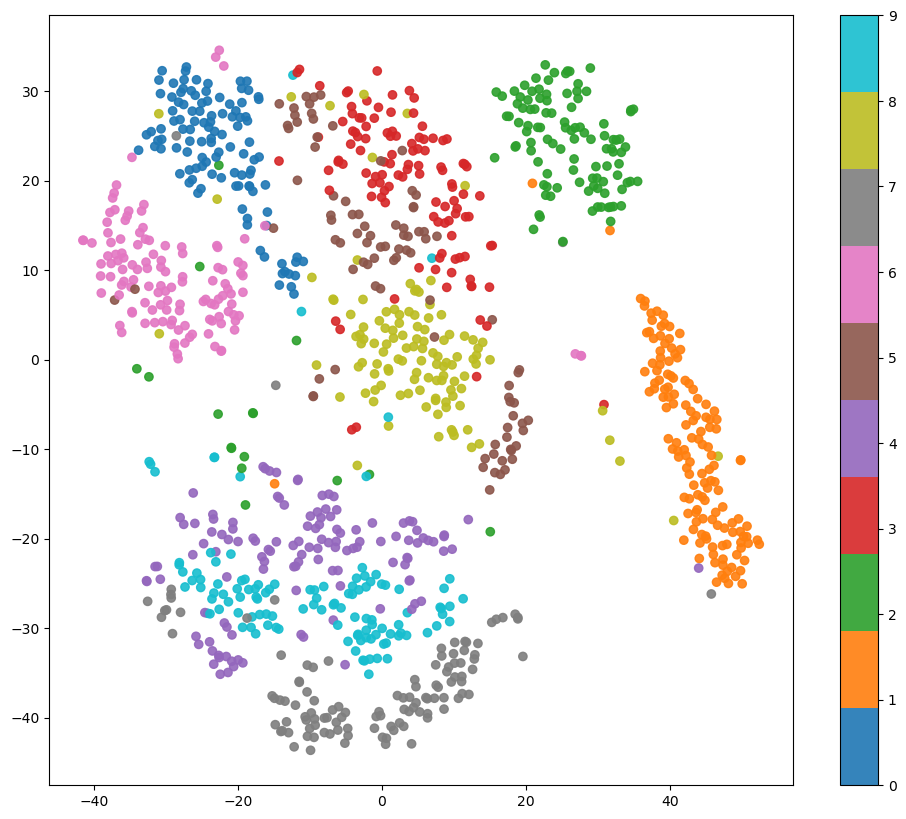

In [10]:
def plot_tsne_oneDomain(x, y, percent=0.05, figsize=(12,10), marker='o', alpha=0.9, blk='True'):
    perm = np.random.permutation(x.shape[0])
    rnd  = perm[:int(np.floor(percent*len(perm)))]
    x    = x[rnd]
    y    = y[rnd]
    x_tr = TSNE().fit_transform(x)
    plt.figure(figsize=figsize)
    plt.scatter(x_tr[:,0], x_tr[:,1], c=y, marker=marker, cmap='tab10', alpha=alpha)
    plt.colorbar()
    plt.show(block=blk)

plot_tsne_oneDomain(np.concatenate((x_train_mnist,x_test_mnist), axis=0),np.concatenate((y_train_mnist,y_test_mnist), axis=0), percent=1/60)
# plot_tsne_oneDomain(np.concatenate((x_train_usps,x_test_usps),   axis=0),np.concatenate((y_train_usps,y_test_usps),   axis=0), percent=1/7)
# plot_tsne_oneDomain(np.concatenate((x_train_svhn,x_test_svhn),   axis=0),np.concatenate((y_train_svhn,y_test_svhn),   axis=0), percent=1/73)

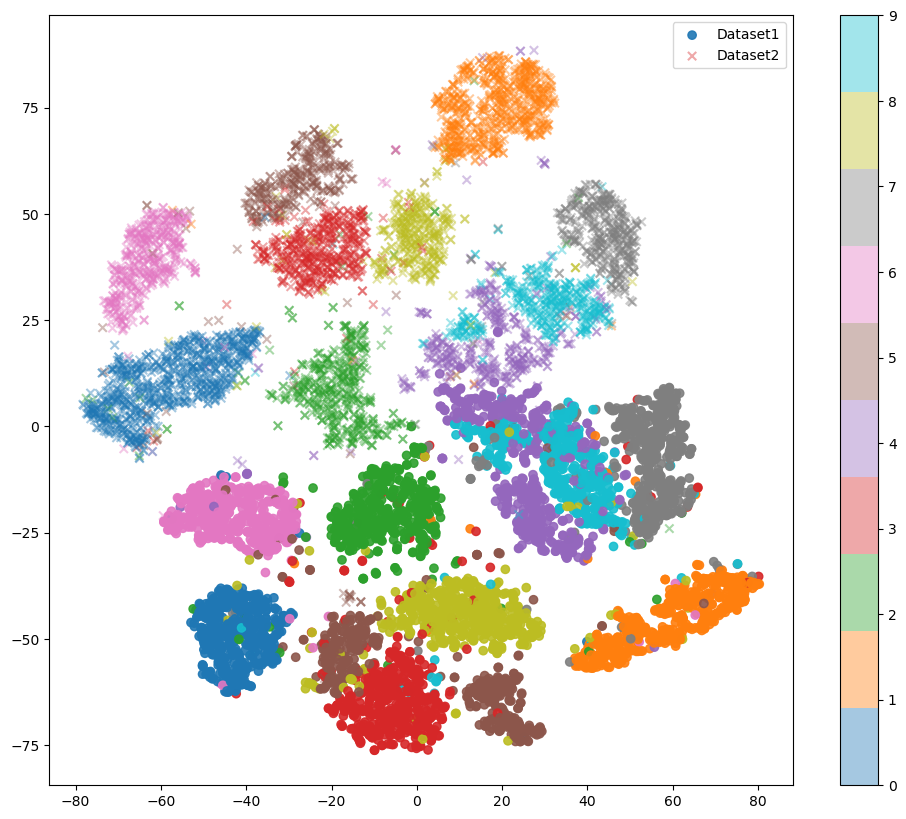

(5000, 256)
(4649, 256)


In [14]:
def plot_tsne_twoDomains(x1, x2, y1, y2, percent1=0.05, percent2=0.05, figsize=(12,10), marker1='o', marker2='d', alpha1=1, alpha2=1, blk='False'): 
    perm1 = np.random.permutation(x1.shape[0])
    rnd1  = perm1[:int(np.floor(percent1*len(perm1)))]
    perm2 = np.random.permutation(x2.shape[0])
    rnd2  = perm2[:int(np.floor(percent2*len(perm2)))]
    x1,x2 = x1[rnd1], x2[rnd2]
    y1,y2 = y1[rnd1], y2[rnd2]     
    x_tot = np.concatenate((x1,x2), axis=0)
    x_tr  = TSNE().fit_transform(x_tot)
    x_t1  = x_tr[:len(rnd1),:]
    x_t2  = x_tr[len(rnd1):,:]
    plt.figure(figsize=figsize)
    plt.scatter(x_t1[:,0], x_t1[:,1], c=y1, marker=marker1, cmap='tab10', alpha=alpha1, label='Dataset1')
    plt.scatter(x_t2[:,0], x_t2[:,1], c=y2, marker=marker2, cmap='tab10', alpha=alpha2, label='Dataset2')
    plt.colorbar()
    plt.legend()
    plt.show(block=blk)
    return x1,x2,y1,y2      #############temporary for faster OT check #######


x_mnist,x_usps,y_mnist,y_usps = plot_tsne_twoDomains(np.concatenate((x_train_mnist,x_test_mnist), axis=0), np.concatenate((x_train_usps,x_test_usps), axis=0),\
             np.concatenate((y_train_mnist,y_test_mnist), axis=0), np.concatenate((y_train_usps,y_test_usps), axis=0),\
             percent1=1/14, percent2=7/14, figsize=(12,10), marker1='o', marker2='x', alpha1=0.9, alpha2=0.4, blk='True')   

print(x_mnist.shape)
print(x_usps.shape)

## Compute the Distance (Cost) matrix between domains
- **Dmu:** mnist and usps
- **Dms:** mnist and svhn
- **Dus:** usps and svhn

Euclidean metric is chosen as a metric of distance, resulting in the **optimal block diagonal cost matrix**

### clear some variables, for RAM efficiency

In [15]:
del x_test_mnist
del x_test_svhn
del x_test_usps
del x_train_mnist
del x_train_svhn
del x_train_usps

del y_test_mnist
del y_test_svhn
del y_test_usps
del y_train_mnist
del y_train_svhn
del y_train_usps

In [16]:
### put classes together to have "block" distance matrices      
def data_class(x,y):
    ind   = []
    y_out = []
    x_out = []
    for i in range(10):
        ind.append(np.where(y==i))
 
    temp  = np.shape(ind[0][0])
    y_out = np.zeros(temp) + 0
    x_out = x[ind[0]]
    for i in range(1,10):
        y_out = np.concatenate((y_out, np.zeros( np.shape(ind[i][0]))+i))
        x_out = np.concatenate((x_out, x[ind[i]]))
    return x_out, y_out

x_mnist, y_mnist = data_class(x_mnist,y_mnist)
x_usps,  y_usps  = data_class(x_usps, y_usps)

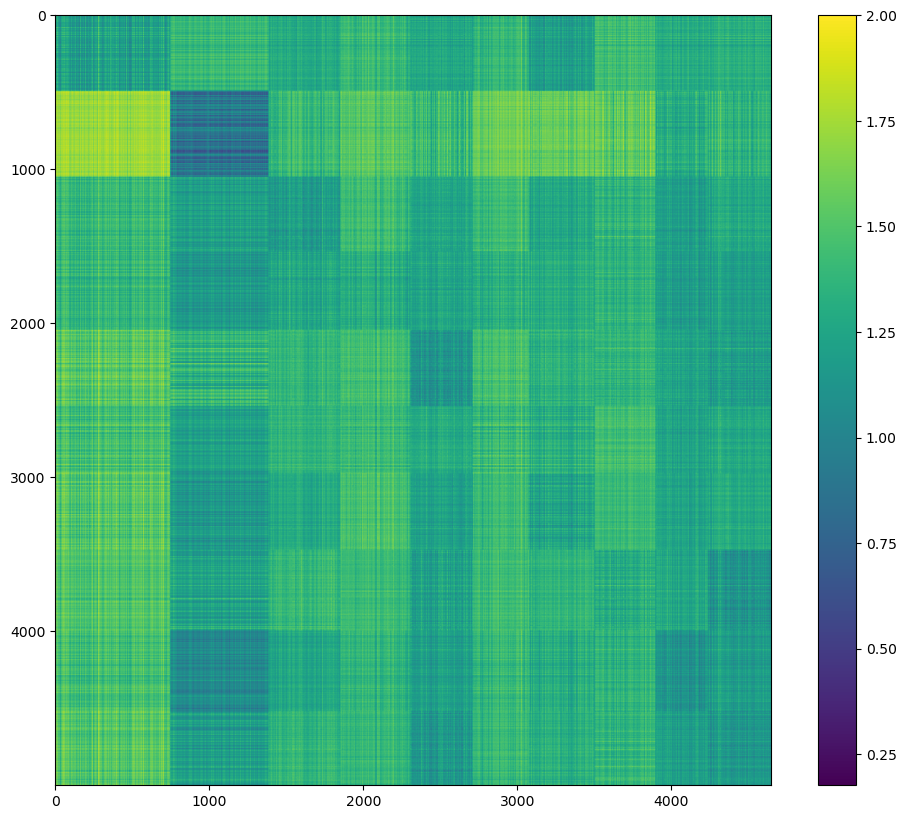

In [17]:
#### cost matrix: mnist-usps
Dmu = ot.dist(x_mnist,x_usps)
plt.figure(figsize=(12,10))
plt.imshow(Dmu)
plt.colorbar()

## Compute the Optimal plan using different methods and optimization algorithms
 - emd  (No regularization)
 - sinkhorn (regularization)
 - DAGP, our paper (No regularization)

 assume uniform distributions for datapoints. 


In [15]:
emd  = ot.emd(ot.unif(len(y_mnist)), ot.unif(len(y_usps)), Dmu, numItermax=1e9)
plan = emd

In [16]:
reg  = 1e-2
sink = ot.sinkhorn(ot.unif(len(y_mnist)), ot.unif(len(y_usps)), Dmu, reg, verbose=False, stopThr=1e-6)
# plan = sink

In [19]:
import Utils
from Utils import dagp_OT_DA

dagp = dagp_OT_DA(D         = Dmu,
                  nN        = 8,
                  edge_prob = 1.0,
                  step_size = 0.01,
                  rho       = 0.5,
                  alpha     = 0.3,
                  ldf_W     = 2,
                  ldf_Q     = 2,
                  max_iter  = 100,
                  eps       = 0.05,
                  eps_lp    = 0.001
                  )

## Transfer source data points to target domain

In [ ]:
plan1 = dagp
plan2 = emd
plan3 = sink
x_transfered1 = len(y_mnist)*np.matmul(plan1, x_usps)
x_transfered2 = len(y_mnist)*np.matmul(plan2, x_usps)
x_transfered3 = len(y_mnist)*np.matmul(plan3, x_usps)

In [ ]:
# _,_,_,_ = plot_tsne_twoDomains(x_transfered1, x_usps, y_mnist, y_usps,\
#              percent1=1, percent2=1, figsize=(20,16), marker1='o', marker2='x', alpha1=0.7, alpha2=0.7, blk='True')   

# _,_,_,_ = plot_tsne_twoDomains(x_transfered2, x_usps, y_mnist, y_usps,\
#              percent1=1, percent2=1, figsize=(20,16), marker1='o', marker2='x', alpha1=0.7, alpha2=0.7, blk='True')   

# _,_,_,_ = plot_tsne_twoDomains(x_transfered3, x_usps, y_mnist, y_usps,\
#              percent1=1, percent2=1, figsize=(20,16), marker1='o', marker2='x', alpha1=0.7, alpha2=0.7, blk='True')   

/Users/firooz/opt/anaconda3/envs/OT/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/firooz/opt/anaconda3/envs/OT/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


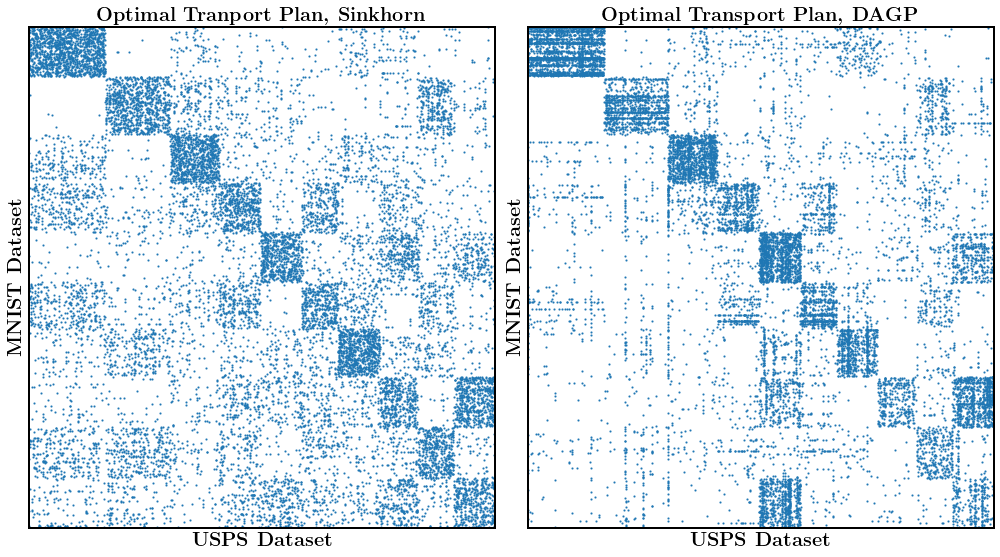

In [ ]:
output_path = "Fig_plans"

matplotlib.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "Arial"
font = FontProperties()
font.set_size(20)
font2 = FontProperties()
font2.set_size(20)
mark_every = 2
linewidth = 2

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.spy(sink, precision=1.3e-5, markersize=1)
plt.tick_params(labelsize=16, width=3)
plt.xlabel(r'\textbf{USPS Dataset}', fontproperties=font)
plt.ylabel(r'\textbf{MNIST Dataset}', fontproperties=font2)
plt.xticks(ticks=[], labels=[]  )
plt.yticks([],[])
plt.title(r'\textbf{Optimal Tranport Plan, Sinkhorn}', FontProperties= font2)
plt.tight_layout()
plt.subplot(122)
plt.spy(plan, precision=1.3e-5, markersize=1)
plt.tick_params(labelsize=16, width=3)
plt.xlabel(r'\textbf{USPS Dataset}', fontproperties=font)
plt.ylabel(r'\textbf{MNIST Dataset}', fontproperties=font2)
plt.xticks(ticks=[], labels=[]  )
plt.yticks([],[])
plt.tight_layout()
plt.title(r'\textbf{Optimal Transport Plan, DAGP}', FontProperties=font2)
path = os.path.join(output_path, 'plans100dpi')
plt.savefig( path + ".jpg", format = 'jpg', dpi = 100, pad_inches=0.05, bbox_inches ='tight')
plt.show()